In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data_util
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torchsummary import summary
from sklearn.metrics import r2_score

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)

device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
elec = pd.read_csv('elec_merge.csv')
nelec = pd.read_csv('n_elec_merge.csv')
dhw = pd.read_csv('dhw_merge.csv')

In [4]:
elec = elec.drop(['YEAR'], axis=1)
nelec = nelec.drop(['YEAR'], axis=1)
dhw = dhw.drop(['YEAR'], axis=1)

In [5]:
input_nelec = nelec.iloc[:-1,].reset_index(drop=True)
output_nelec = nelec[['n_elec']].iloc[1:].reset_index(drop=True)
output_nelec.columns = ['nelec']

input_elec = elec.iloc[:-1,].reset_index(drop=True)
output_elec = elec[['ELEC']].iloc[1:].reset_index(drop=True)
output_elec.columns = ['elec']

input_dhw = dhw.iloc[:-1,].reset_index(drop=True)
output_dhw = dhw[['DHW']].iloc[1:].reset_index(drop=True)
output_dhw.columns = ['dhw']

nelec = pd.concat([input_nelec, output_nelec], axis=1)
elec = pd.concat([input_elec, output_elec], axis=1)
dhw = pd.concat([input_dhw, output_dhw], axis=1)

# input_nelec = nelec.iloc[:-1,:-1].reset_index(drop=True)
# output_nelec = nelec[['n_elec']].iloc[:-1].reset_index(drop=True)
# output_nelec2 = nelec['n_elec'][1:].reset_index(drop=True)
# output_nelec['nelec'] = output_nelec2

# input_elec = elec.iloc[:-1,:-1].reset_index(drop=True)
# output_elec = elec[['ELEC']].iloc[:-1].reset_index(drop=True)
# output_elec2= elec['ELEC'][1:].reset_index(drop=True)
# output_elec['elec'] = output_elec2

# input_dhw = dhw.iloc[:-1,:-1].reset_index(drop=True)
# output_dhw = dhw[['DHW']].iloc[:-1].reset_index(drop=True)
# output_dhw2 = dhw['DHW'][1:].reset_index(drop=True)
# output_dhw['dhw'] = output_dhw2

In [6]:
scaler_nelec = MinMaxScaler()
scaler_elec = MinMaxScaler()
scaler_dhw = MinMaxScaler()

scaler_nelec.fit(nelec)
scaler_elec.fit(elec)
scaler_dhw.fit(dhw)

scaled_nelec = scaler_nelec.transform(nelec)
scaled_elec = scaler_elec.transform(elec)
scaled_dhw = scaler_dhw.transform(dhw)

nelec = pd.DataFrame(scaled_nelec, index=nelec.index, columns=nelec.columns)
elec = pd.DataFrame(scaled_elec, index=elec.index, columns=elec.columns)
dhw = pd.DataFrame(scaled_dhw, index=dhw.index, columns=dhw.columns)

# scaler_nelec = MinMaxScaler()
# scaler_elec = MinMaxScaler()
# scaler_dhw = MinMaxScaler()

# scaler_nelec.fit(input_nelec)
# scaler_elec.fit(input_elec)
# scaler_dhw.fit(input_dhw)

# scaled_nelec = scaler_nelec.transform(input_nelec)
# scaled_elec = scaler_elec.transform(input_elec)
# scaled_dhw = scaler_dhw.transform(input_dhw)

# nelec_x = pd.DataFrame(scaled_nelec, index=input_nelec.index, columns=input_nelec.columns)
# elec_x = pd.DataFrame(scaled_elec, index=input_elec.index, columns=input_elec.columns)
# dhw_x = pd.DataFrame(scaled_dhw, index=input_dhw.index, columns=input_dhw.columns)

# nelec = pd.concat([nelec_x, output_nelec], axis=1)
# elec = pd.concat([elec_x, output_elec], axis=1)
# dhw = pd.concat([dhw_x, output_dhw], axis=1)

In [7]:
standard_nelec = int(len(nelec) * 0.7)
standard_elec = int(len(elec) * 0.7)
standard_dhw = int(len(dhw) * 0.7)

nelec_train = nelec.iloc[:standard_nelec]
nelec_test = nelec.iloc[standard_nelec:].reset_index(drop=True)

elec_train = elec.iloc[:standard_elec]
elec_test = elec.iloc[standard_elec:].reset_index(drop=True)

dhw_train = dhw.iloc[:standard_dhw]
dhw_test = dhw.iloc[standard_dhw:].reset_index(drop=True)

In [8]:
nelec_trainx = nelec_train.drop(['nelec'], axis=1)
nelec_trainy = nelec_train[['nelec']]

nelec_testx = nelec_test.drop(['nelec'], axis=1)
nelec_testy = nelec_test[['nelec']]

elec_trainx = elec_train.drop(['elec'], axis=1)
elec_trainy = elec_train[['elec']]

elec_testx = elec_test.drop(['elec'], axis=1)
elec_testy = elec_test[['elec']]

dhw_trainx = dhw_train.drop(['dhw'], axis=1)
dhw_trainy = dhw_train[['dhw']]

dhw_testx = dhw_test.drop(['dhw'], axis=1)
dhw_testy = dhw_test[['dhw']]

In [9]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

nelec_trainx, nelec_trainy = buildDataSet(nelec_trainx, nelec_trainy, 7)
nelec_testx, nelec_testy = buildDataSet(nelec_testx, nelec_testy, 7)

elec_trainx, elec_trainy = buildDataSet(elec_trainx, elec_trainy, 7)
elec_testx, elec_testy = buildDataSet(elec_testx, elec_testy, 7)

dhw_trainx, dhw_trainy = buildDataSet(dhw_trainx, dhw_trainy, 7)
dhw_testx, dhw_testy = buildDataSet(dhw_testx, dhw_testy, 7)

In [10]:
print(nelec_trainx.shape)
print(nelec_trainy.shape)
print(nelec_testx.shape)
print(nelec_testy.shape)
print(elec_trainx.shape)
print(elec_trainy.shape)
print(elec_testx.shape)
print(elec_testy.shape)
print(dhw_trainx.shape)
print(dhw_trainy.shape)
print(dhw_testx.shape)
print(dhw_testy.shape)

(20409, 7, 12)
(20409, 1)
(8744, 7, 12)
(8744, 1)
(2984, 7, 12)
(2984, 1)
(1275, 7, 12)
(1275, 1)
(20409, 7, 12)
(20409, 1)
(8744, 7, 12)
(8744, 1)


In [11]:
# 텐서로 변환
nelec_trainx_tensor = torch.FloatTensor(nelec_trainx)
nelec_trainy_tensor = torch.FloatTensor(nelec_trainy)

nelec_testx_tensor = torch.FloatTensor(nelec_testx)
nelec_testy_tensor = torch.FloatTensor(nelec_testy)

elec_trainx_tensor = torch.FloatTensor(elec_trainx)
elec_trainy_tensor = torch.FloatTensor(elec_trainy)

elec_testx_tensor = torch.FloatTensor(elec_testx)
elec_testy_tensor = torch.FloatTensor(elec_testy)

dhw_trainx_tensor = torch.FloatTensor(dhw_trainx)
dhw_trainy_tensor = torch.FloatTensor(dhw_trainy)

dhw_testx_tensor = torch.FloatTensor(dhw_testx)
dhw_testy_tensor = torch.FloatTensor(dhw_testy)

In [12]:
# 텐서 형태로 데이터 정의
nelec_train = TensorDataset(nelec_trainx_tensor, nelec_trainy_tensor)
nelec_test = TensorDataset(nelec_testx_tensor, nelec_testy_tensor)

elec_train = TensorDataset(elec_trainx_tensor, elec_trainy_tensor)
elec_test = TensorDataset(elec_testx_tensor, elec_testy_tensor)

dhw_train = TensorDataset(dhw_trainx_tensor, dhw_trainy_tensor)
dhw_test = TensorDataset(dhw_testx_tensor, dhw_testy_tensor)

In [13]:
batch_for_nelec_train = 512#len(nelec_trainx)
batch_for_nelec_test = 512#len(nelec_testx)
batch_for_elec_train = 75#len(elec_trainx)
batch_for_elec_test = 75#len(elec_testx)
batch_for_dhw_train = 512#len(dhw_trainx)
batch_for_dhw_test = 512#len(dhw_testx)

NELEC_train = DataLoader(nelec_train,
                        batch_size=batch_for_nelec_train,
                        shuffle=False,  
                        drop_last=True)

NELEC_test = DataLoader(nelec_test,
                        batch_size=batch_for_nelec_test,
                        shuffle=False,  
                        drop_last=True)

ELEC_train = DataLoader(elec_train,
                        batch_size=batch_for_elec_train,
                        shuffle=False,  
                        drop_last=True)

ELEC_test = DataLoader(elec_test,
                        batch_size=batch_for_elec_test,
                        shuffle=False,  
                        drop_last=True)

DHW_train = DataLoader(dhw_train,
                        batch_size=batch_for_dhw_train,
                        shuffle=False,  
                        drop_last=True)

DHW_test = DataLoader(dhw_test,
                        batch_size=batch_for_dhw_test,
                        shuffle=False,  
                        drop_last=True)

In [14]:
# 데이터셋의 개수를 가정하여 변수에 저장
nelec_train_size = len(nelec_train)
nelec_test_size = len(nelec_test)
elec_train_size = len(elec_train)
elec_test_size = len(elec_test)
dhw_train_size = len(dhw_train)
dhw_test_size = len(dhw_test)

# 각 DataLoader에서 생성되는 배치의 개수 계산
nelec_train_batches = nelec_train_size // batch_for_nelec_train
nelec_test_batches = nelec_test_size // batch_for_nelec_test
elec_train_batches = elec_train_size // batch_for_elec_train
elec_test_batches = elec_test_size // batch_for_elec_test
dhw_train_batches = dhw_train_size // batch_for_dhw_train
dhw_test_batches = dhw_test_size // batch_for_dhw_test

# 결과 출력
print("nelec_train batches:", nelec_train_batches)
print("nelec_test batches:", nelec_test_batches)
print("elec_train batches:", elec_train_batches)
print("elec_test batches:", elec_test_batches)
print("dhw_train batches:", dhw_train_batches)
print("dhw_test batches:", dhw_test_batches)

nelec_train batches: 39
nelec_test batches: 17
elec_train batches: 39
elec_test batches: 17
dhw_train batches: 39
dhw_test batches: 17


# 모델 구조 선언

In [15]:
import torch.nn as nn
import torch.nn.functional as F

### GradientReversalLayer

In [16]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return (grad_output * -1), None

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x):
        return GradientReversalFunction.apply(x)

### LSTM for Feature Extraction

In [17]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [18]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm1 = nn.LSTM(12, 64, batch_first=True)
        self.bn1 = nn.BatchNorm1d(7)
        
        self.lstm2 = nn.LSTM(64, 64, batch_first=True)
        self.bn2 = nn.BatchNorm1d(7)
        
        self.lstm3 = nn.LSTM(64,64, batch_first=True)
        
        self.fc = nn.Linear(64, 64, bias=False)
        self.fc2 = nn.Linear(64, 100, bias=False)
        self.bn3 = nn.BatchNorm1d(7)
        
        self.dropout = nn.Dropout(0.5)
        self.swish = Swish()
        self.tanh = nn.Tanh()

        
    def forward(self, x):
        x, (h,c) = self.lstm1(x)
        x = self.bn1(x)
        x = self.tanh(x)

        x, (h, c) = self.lstm2(x, (h, c))
        x = self.bn2(x)
        x = self.tanh(x)
        
        x, _ = self.lstm3(x, (h, c))
        x = self.bn2(x)
        x = self.tanh(x)
        
        x = self.fc(x)
        x = self.bn3(x)
        x = self.fc2(x[:,-1,:])
        x = self.dropout(x)
        x = self.swish(x)
        return x

In [19]:
# hoxy = lstm()
# inputx = torch.randn(1024,7,12)
# hoxy2 = hoxy(inputx)
# print(hoxy2.shape)

In [20]:
class domain_regression(nn.Module):
    def __init__(self):
        super(domain_regression, self).__init__()
        self.regression_layer1 = nn.Linear(100, 100)
        self.regression_layer2 = nn.Linear(100, 100)
        self.regression_layer3 = nn.Linear(100, 100)
        self.regression_layer4 = nn.Linear(100, 1)
        self.swish = Swish()
        
    def forward(self, x):
        x = self.swish(self.regression_layer1(x))
        x = self.swish(self.regression_layer2(x))
        x = self.swish(self.regression_layer3(x))
        x = self.swish(self.regression_layer4(x))
        return x

### Domain Classification

In [21]:
class domain_classfication(nn.Module):
    def __init__(self):
        super(domain_classfication, self).__init__()
        self.classification_layer0 = GradientReversalLayer()
        self.classification_layer1 = nn.Linear(100, 100)
        self.classification_layer2 = nn.Linear(100,100)
        self.classification_layer3 = nn.Linear(100,100)
        self.classification_layer4 = nn.Linear(100, 1)
        self.swish = Swish()
        
    def forward(self, x):
        x = self.classification_layer0(x)
        x = self.swish(self.classification_layer1(x))
        x = self.swish(self.classification_layer2(x))
        x = self.swish(self.classification_layer3(x))
        x = torch.sigmoid(self.classification_layer4(x))
        return x 

### Set the DANN

In [22]:
class dann(nn.Module):
    def __init__(self, lstm):
        super(dann, self).__init__()
        self.lstm = lstm
        self.regression = domain_regression()
        self.classification = domain_classfication()
        
    def forward(self, x):
        feature = self.lstm(x)
        reg_output = self.regression(feature)
        cla_output = self.classification(feature)
        
        return reg_output, cla_output

### Loss 선언

In [23]:
class dann_loss(nn.Module):
    def __init__(self):
        super(dann_loss, self).__init__()
        self.reg = nn.L1Loss() # 회귀 L1 손실 == MAE
        self.cla = nn.BCEWithLogitsLoss() # 도메인 분류
        
    def forward(self, result, reg_real, domain_num, alpha=1):
        reg_output, cla_output = result
        batch_size = reg_output.shape[0]
        cla_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        
        reg_loss = self.reg(reg_output, reg_real)
        cla_loss = self.cla(cla_output, cla_target)
        cla_loss2 = cla_loss * alpha
        
        loss = reg_loss + cla_loss2
        
        return loss, reg_loss, cla_loss2

In [24]:
my_lstm = lstm().to(device)
model = dann(my_lstm).to(device)
loss_fn = dann_loss().to(device)

# 훈련

In [25]:
from torch.optim.lr_scheduler import LinearLR

alpha = 1.0
epochs = 200

model.train() # 훈련 모드 설정

optimizer= torch.optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters = epochs * len(NELEC_train))

patience = 100  # Early stopping을 위한 기다리는 최대 epoch 수
best_loss = float('inf')
best_source_loss = float('inf')
best_model_state_dict = None
counter = 10  # Early stopping 카운터

for i in range(1, epochs + 1):
    total_loss = 0
    source_total_loss = 0
    target_total_loss = 0
    src_reg_total = 0
    src_cla_total = 0
    tar_reg_total = 0
    tar_cal_total = 0
    reg_loss_total = 0
    cla_loss_total = 0
    for step, (source_data, target_data) in enumerate(zip(NELEC_train, ELEC_train)):
        source_x = source_data[0].to(device)
        source_y = source_data[1].to(device)
        target_x = target_data[0].to(device)
        target_y = target_data[1].to(device)
        #print(source_x.shape)
        #print(source_y.shape)
        #print(target_x.shape)
        #print(target_y.shape)
        # 순전파
        source_result = model(source_x)
        target_result = model(target_x)
        #print(source_result[0].shape)
        #print(target_result[0].shape)
        #print(source_result[1].shape)
        #print(target_result[1].shape)
        # 순전파 loss
        source_loss, source_reg_loss, source_cla_loss = loss_fn(source_result, source_y, 1, alpha=alpha) # 소스 도메인 레이블 1
        target_loss, target_reg_loss, target_cla_loss = loss_fn(target_result, target_y, 0, alpha=alpha) # 타겟 도메인 레이블 0
        
        loss = source_loss + target_loss
        reg_loss = source_reg_loss + target_reg_loss
        cla_loss = source_cla_loss + target_cla_loss
        
        #src_reg_total += source_reg_loss.item()
        #src_cla_total += source_cla_loss.item()
        #tar_reg_total += target_reg_loss.item()
        #tar_cal_total += target_cla_loss.item()
        
        #source_total_loss += source_loss.item()
        #target_total_loss += target_loss.item()
        
        reg_loss_total += reg_loss.item()
        cla_loss_total += cla_loss.item()
        
        total_loss += loss.item()
        
        # 그래디언트 계산 및 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Early stopping 확인
    if reg_loss_total / len(NELEC_train) < best_loss:
        best_loss = reg_loss_total / len(NELEC_train)
        best_model_state_dict = model.state_dict()
        counter = 0  # Counter 초기화
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {i}')
            break

    print('Epoch : %d, Total Avg Loss : %.4f' % (i, total_loss / len(NELEC_train)))     
    #print('Source Avg Loss : %.4f' % (source_total_loss / len(NELEC_train)))
    #print('Target Avg Loss : %.4f' % (target_total_loss / len(NELEC_train)))
    #print('Source Avg reg Loss : %.4f' % (src_reg_total / len(NELEC_train)))
    #print('Target Avg reg Loss : %.4f' % (tar_reg_total / len(NELEC_train)))
    #print('Source Avg cla Loss : %.4f' % (src_cla_total / len(NELEC_train)))
    #print('Target Avg cla Loss : %.4f' % (tar_cal_total / len(NELEC_train)))
    print('Avg Regression Loss : %.4f' % (reg_loss_total / len(NELEC_train)))
    print('Avg Classification Loss : %.4f' % (cla_loss_total / len(NELEC_train)))
    print('')
    
    # source_loss가 가장 낮은 경우 모델 가중치 저장
    if reg_loss_total / len(NELEC_train) < best_source_loss:
        best_source_loss = reg_loss_total / len(NELEC_train)
        best_model_state_dict = model.state_dict()

# 최상의 모델을 파일로 저장
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, '0811_experiment_3.pth')
    #torch.save(model, "model.pth")

Epoch : 1, Total Avg Loss : 1.8137
Avg Regression Loss : 0.3753
Avg Classification Loss : 1.4384

Epoch : 2, Total Avg Loss : 1.7252
Avg Regression Loss : 0.2992
Avg Classification Loss : 1.4259

Epoch : 3, Total Avg Loss : 1.6534
Avg Regression Loss : 0.2368
Avg Classification Loss : 1.4167

Epoch : 4, Total Avg Loss : 1.6118
Avg Regression Loss : 0.2055
Avg Classification Loss : 1.4064

Epoch : 5, Total Avg Loss : 1.5749
Avg Regression Loss : 0.1792
Avg Classification Loss : 1.3957

Epoch : 6, Total Avg Loss : 1.5362
Avg Regression Loss : 0.1699
Avg Classification Loss : 1.3663

Epoch : 7, Total Avg Loss : 1.5570
Avg Regression Loss : 0.1999
Avg Classification Loss : 1.3571

Epoch : 8, Total Avg Loss : 1.5952
Avg Regression Loss : 0.2255
Avg Classification Loss : 1.3697

Epoch : 9, Total Avg Loss : 1.6004
Avg Regression Loss : 0.2230
Avg Classification Loss : 1.3774

Epoch : 10, Total Avg Loss : 1.5486
Avg Regression Loss : 0.1913
Avg Classification Loss : 1.3573

Epoch : 11, Total A

In [26]:
# from torchinfo import summary

# summary(model, (512,3,12))

# train 데이터로 테스트

In [27]:
# 저장된 최상의 소스 모델 불러오기
best_source_model2 = dann(my_lstm).to(device)
best_source_model2.load_state_dict(torch.load('0811_experiment_3.pth'))
best_source_model2.eval()  # 평가 모드로 설정

s_pred = []  # MNIST 데이터셋의 예측값을 저장할 리스트
t_pred = []  # SVHN 데이터셋의 예측값을 저장할 리스트
s_real = []
t_real = []
s_d_pred = []
t_d_pred = []

for step, (source_data, target_data) in enumerate(zip(NELEC_train, ELEC_train)):
    sourcex = source_data[0].to(device)
    sourcey = source_data[1].to(device)
    targetx = target_data[0].to(device)
    targety = target_data[1].to(device)

    # 저장된 최상의 모델로 예측
    source_domain_label_pred, source_pred = best_source_model2(sourcex)
    target_domain_label_pred, target_pred = best_source_model2(targetx)

    ## 예측값을 리스트에 저장
    s_pred.extend(source_pred.detach().cpu().numpy())
    t_pred.extend(target_pred.detach().cpu().numpy())
    s_real.extend(sourcey.detach().cpu().numpy())
    t_real.extend(targety.detach().cpu().numpy())
    s_d_pred.extend(source_domain_label_pred.detach().cpu().numpy())
    t_d_pred.extend(target_domain_label_pred.detach().cpu().numpy())

# R2 스코어 계산
s_r2 = r2_score(s_real, s_pred)
t_r2 = r2_score(t_real, t_pred)

print('SOURCE R2 Score:', s_r2)
print('TARGET R2 Score:', t_r2)

SOURCE R2 Score: -0.4109593977855899
TARGET R2 Score: 0.39086817413778807


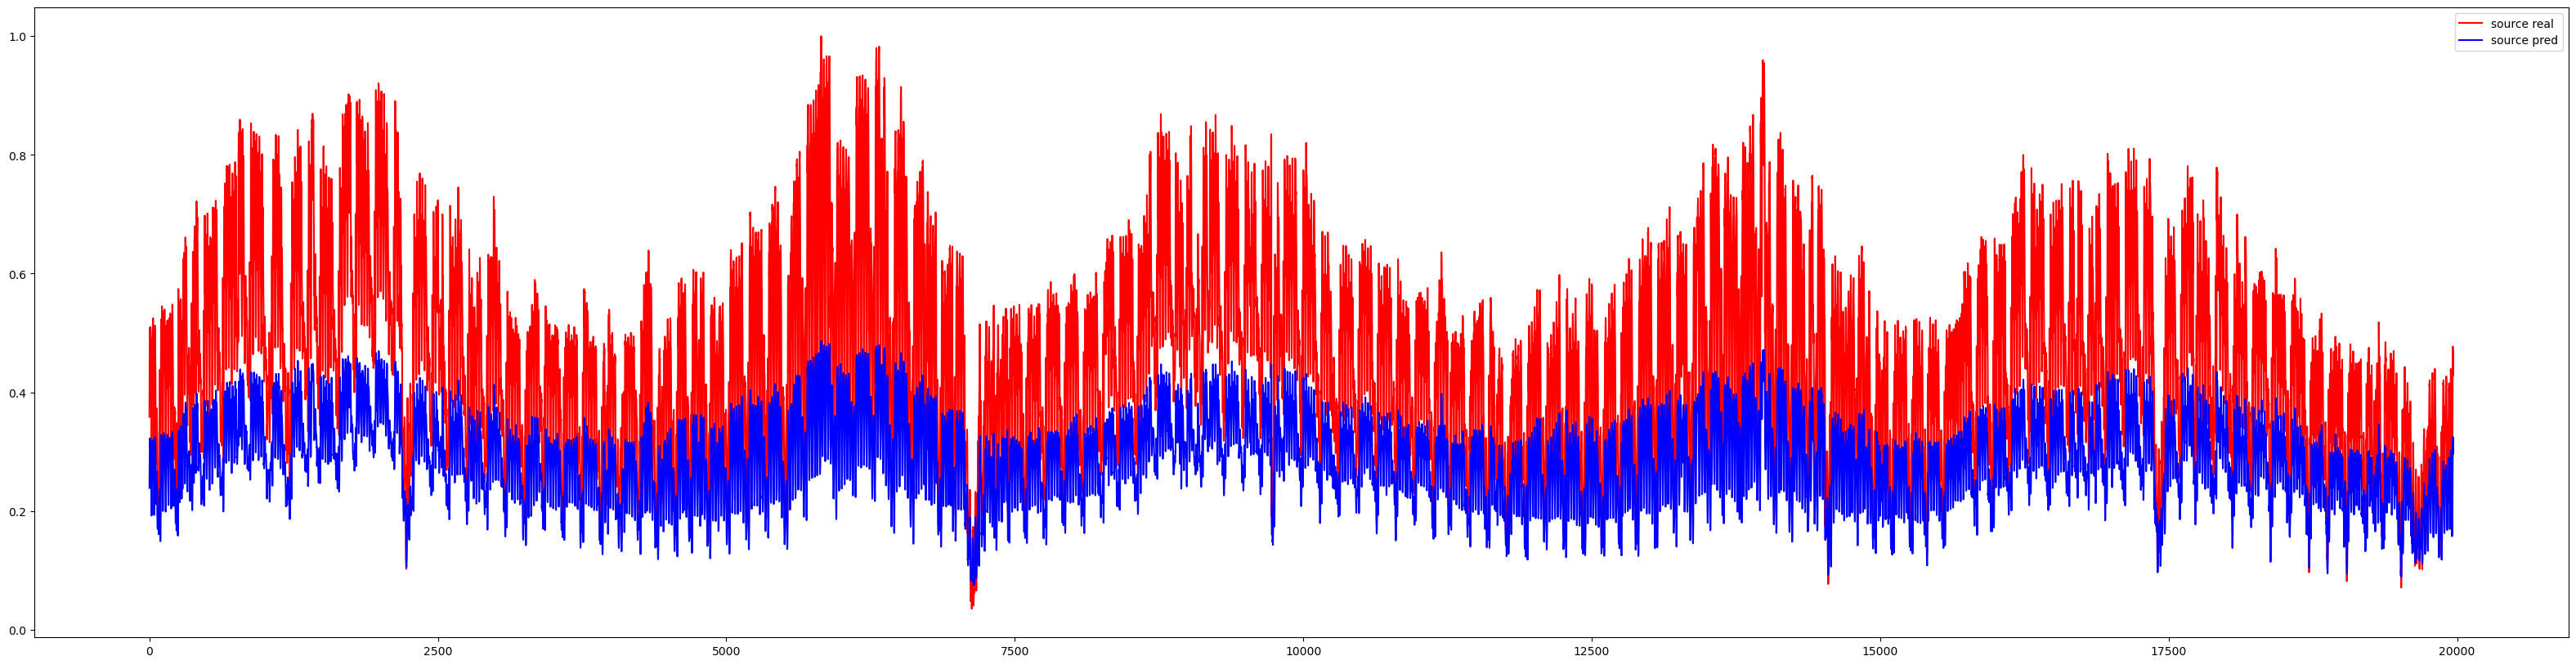

In [28]:
plt.figure(figsize=(40,10))
plt.plot(s_real, color='red', label='source real')
plt.plot(s_pred, color='blue', label='source pred')
plt.legend()
plt.show()

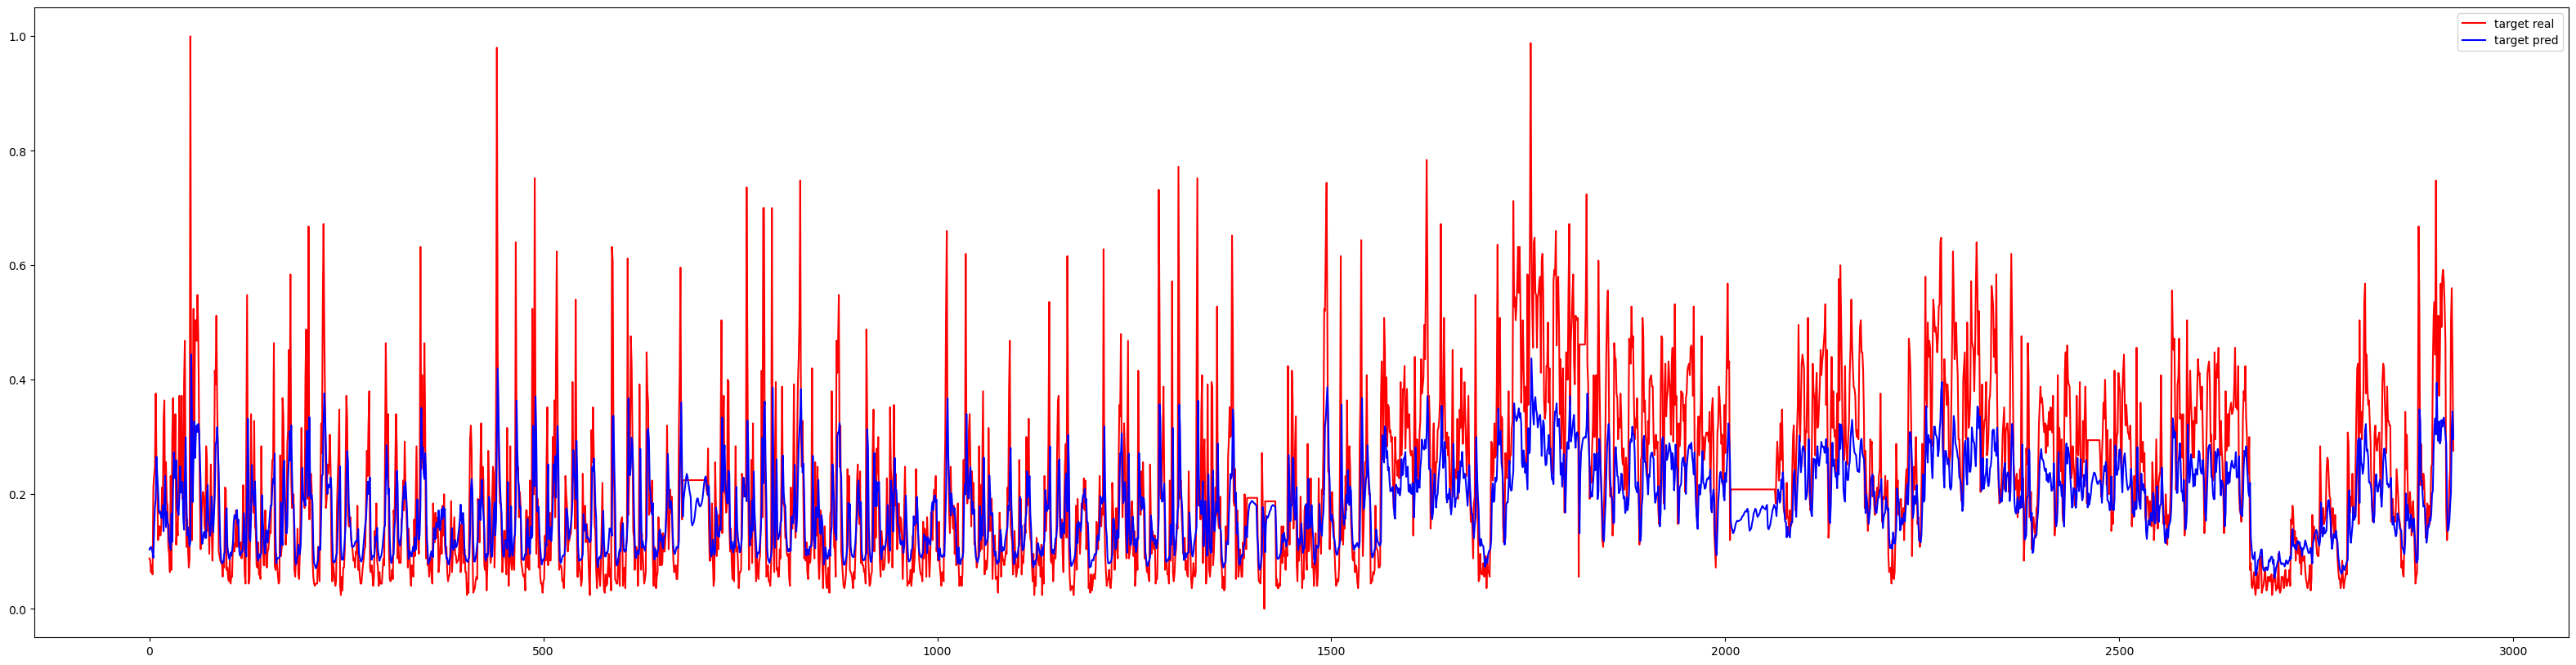

In [29]:
plt.figure(figsize=(40,10))
plt.plot(t_real, color='red', label='target real')
plt.plot(t_pred, color='blue', label='target pred')
plt.legend()
plt.show()

# test 데이터로 테스트

In [30]:
# 저장된 최상의 소스 모델 불러오기
best_source_model2 = dann(my_lstm).to(device)
best_source_model2.load_state_dict(torch.load('0811_experiment_3.pth'))
best_source_model2.eval()  # 평가 모드로 설정

s_pred = []  # MNIST 데이터셋의 예측값을 저장할 리스트
t_pred = []  # SVHN 데이터셋의 예측값을 저장할 리스트
s_real = []
t_real = []


for step, (source_data, target_data) in enumerate(zip(NELEC_test, ELEC_test)):
    sourcex = source_data[0].to(device)
    sourcey = source_data[1].to(device)
    targetx = target_data[0].to(device)
    targety = target_data[1].to(device)

    # 저장된 최상의 모델로 예측
    _, source_pred = best_source_model2(sourcex)
    _, target_pred = best_source_model2(targetx)

    ## 예측값을 리스트에 저장
    s_pred.extend(source_pred.detach().cpu().numpy())
    t_pred.extend(target_pred.detach().cpu().numpy())
    s_real.extend(sourcey.detach().cpu().numpy())
    t_real.extend(targety.detach().cpu().numpy())

# R2 스코어 계산
s_r2 = r2_score(s_real, s_pred)
t_r2 = r2_score(t_real, t_pred)

print('SOURCE R2 Score:', s_r2)
print('TARGET R2 Score:', t_r2)

SOURCE R2 Score: -0.24158782705252912
TARGET R2 Score: -0.017927289639464883


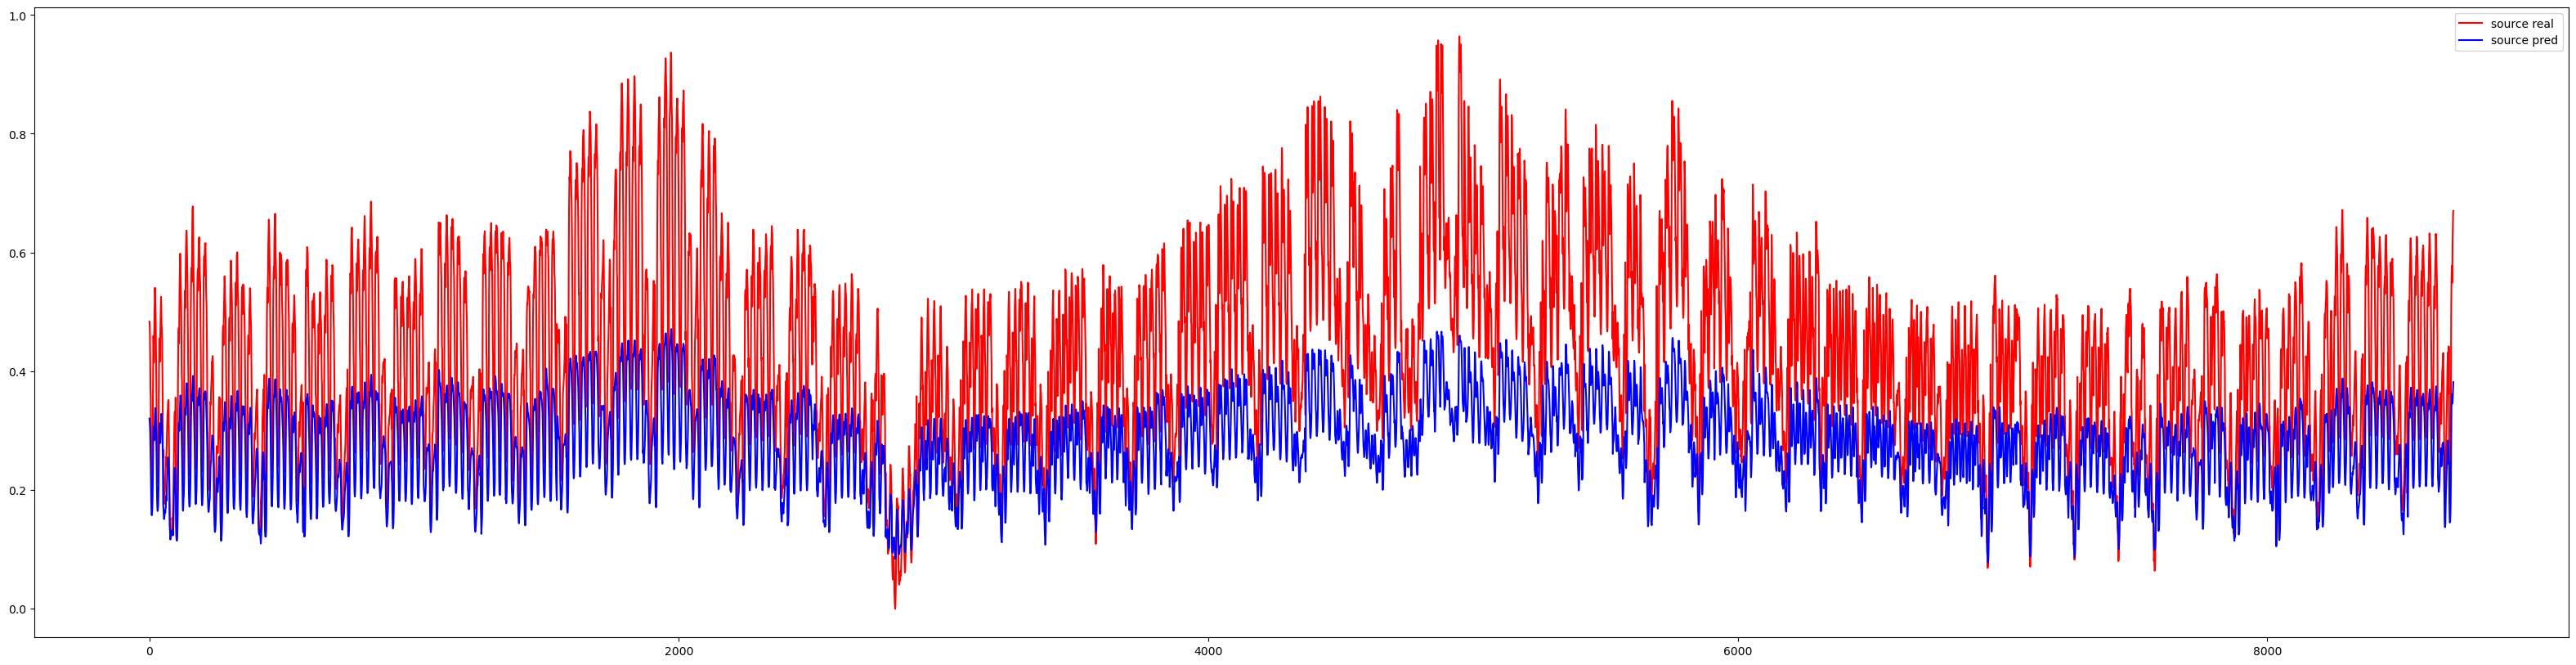

In [31]:
plt.figure(figsize=(40,10))
plt.plot(s_real, color='red', label='source real')
plt.plot(s_pred, color='blue', label='source pred')
plt.legend()
plt.show()

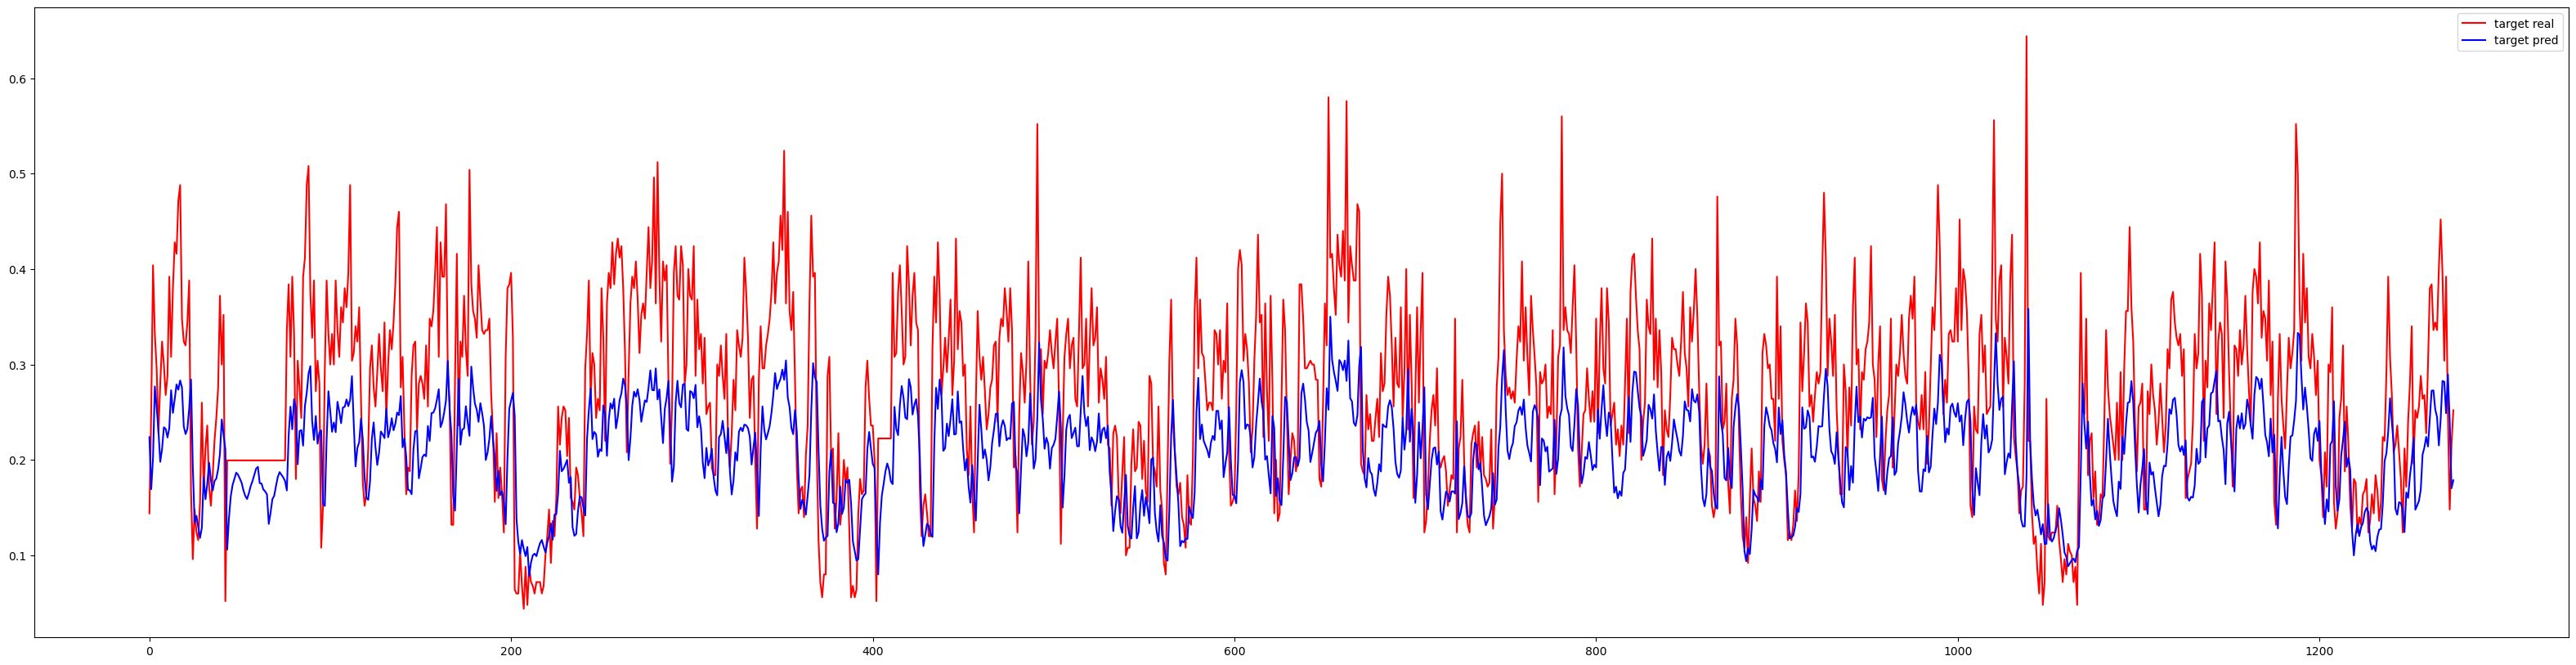

In [32]:
plt.figure(figsize=(40,10))
plt.plot(t_real, color='red', label='target real')
plt.plot(t_pred, color='blue', label='target pred')
plt.legend()
plt.show()

### Domain Embedding Space 시각화

In [33]:
# 가장 앞 batch의 250개씩의 데이터만 샘플링
source_tsne = DataLoader(nelec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

target_tsne = DataLoader(elec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

source_tsne2 = next(iter(source_tsne))
target_tsne2 = next(iter(target_tsne))

source_x_TNSE = source_tsne2[0].to(device)
source_y_TNSE = source_tsne2[1].to(device)

target_x_TNSE = target_tsne2[0].to(device)
target_y_TNSE = target_tsne2[1].to(device)

# 학습된 모델의 LSTM 부분만 활용 (100차원 임베딩 벡터를 받아오는 과정)
source_vector = model.lstm(source_x_TNSE)
target_vector = model.lstm(target_x_TNSE)

In [34]:
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([source_vector.cpu().detach().numpy(), target_vector.cpu().detach().numpy()]))

tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

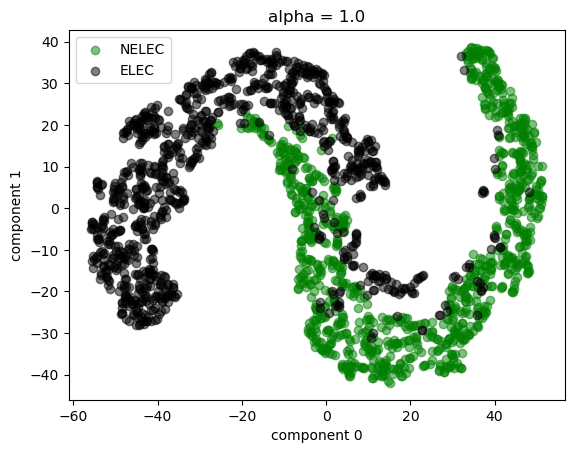

In [35]:
tsne_df_0 = tsne_df.loc[:1000]
tsne_df_1 = tsne_df.loc[1000:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='green', label='NELEC', alpha=0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color='black', label='ELEC', alpha=0.5)

plt.title('alpha = '+ str(alpha))
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()